## Analyze FX Pricing Data
This notebook demonstrates how to use the get_history calls of the Access layer to get SPOT FX pricing data for GBP/USD (Cable) and perform a standard time-series analysis and prediction. The Access layer provides a simplified interface designed for FinCoders. 

### Some popular FX Spot RICs 
 - **GBP=**   : GBP/USD
 - **EUR=**   : EUR/USD
 - **JPY=**   : USD/JPY
 - **CHF=**    :USD/CHF
 - **CAD=**    :USD/CAD
 - **AUD=**    :AUD/USD
 - **CNH=**    :USD/CNH
 - **CNY=**    :USD/CNY
 - **INR=**    :USD/INR
 - **RUB=**    :USD/RUB
 - **BRL=**    :USD/BRL
 - **MXN=**    :USD/MXN
 - **TRY=**    :USD/TRY

#### Learn more

To learn more about the Data Library for Python please join the LSEG Developer Community. By [registering](https://developers.lseg.com/iam/register) and [logging](https://developers.lseg.com/content/devportal/en_us/initCookie.html) into the LSEG Developer Community portal you will have free access to a number of learning materials like 
 [Quick Start guides](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start), 
 [Tutorials](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/learning), 
 [Documentation](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/docs)
 and much more.

#### Getting Help and Support

If you have any questions regarding using the API, please post them on 
this [Q&A Forum](https://community.developers.refinitiv.com/spaces/321/index.html). 
The LSEG Developer Community will be happy to help. 

----

## Some Imports to start with

In [1]:
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing
from refinitiv.data.content.historical_pricing import Intervals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import asyncio
from datetime import datetime,timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## Open the data session

The open_session() function creates and open sessions based on the information contained in the refinitiv-data.config.json configuration file. Please edit this file to set the session type and other parameters required for the session you want to open.

In [2]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x7f855a6dcbb0 {name='codebook'}>

## Retrieve data

### Get daily data for FX pair (GBP=)

In [3]:
dNow = datetime.now().date()
sdate = dNow - timedelta(days=640)
print(dNow,sdate)

spot_df = rd.get_history(universe='GBP=',fields=['BID'],interval="daily", start = str(sdate) , end = str(dNow))
spot_df.columns = ['SPOT']
spot_df

2023-11-27 2022-02-25


,SPOT
Date,
2022-02-28,1.3419
2022-03-01,1.3321
2022-03-02,1.3403
2022-03-03,1.3346
2022-03-04,1.3225
...,...
2023-11-20,1.2504
2023-11-21,1.2537
2023-11-22,1.2492


### Check min max

In [4]:
print('Min: ', spot_df.index.min(), ' Max: ', spot_df.index.max(), ' Count: ', len(spot_df))

Min:  2022-02-28 00:00:00  Max:  2023-11-24 00:00:00  Count:  455


In [5]:
def test_stationarity(timeseries):
    '''A function to plot timeseries alongside the rolling mean/std
    and test stationarity using Dickey-Fuller test'''
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.figure(figsize=(16,7))
    plt.plot(timeseries.index, timeseries.to_list(), label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Original Timeseries')
    
    plt.show()

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### Plot the Spot price Time-Series

Text(0, 0.5, 'Price')

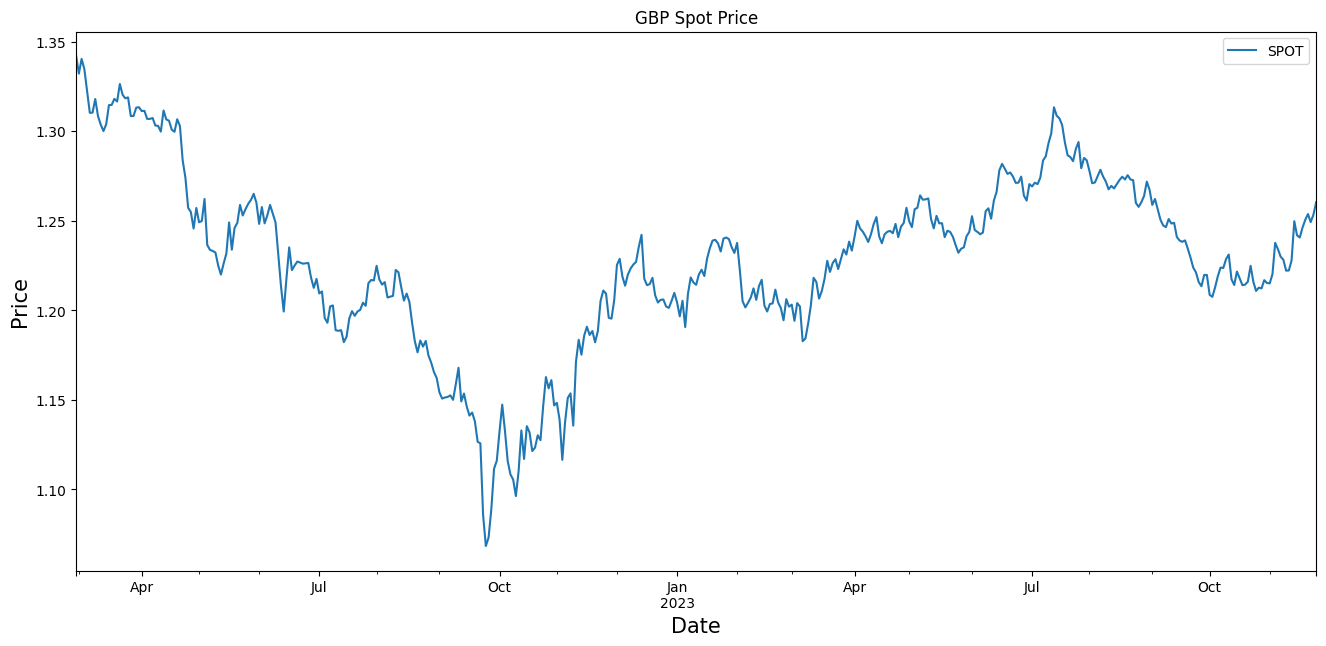

In [6]:
spot_df.plot(title= 'GBP Spot Price',figsize=(16, 7))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)

### Calculate 12 days rolling average

Text(0, 0.5, 'Price')

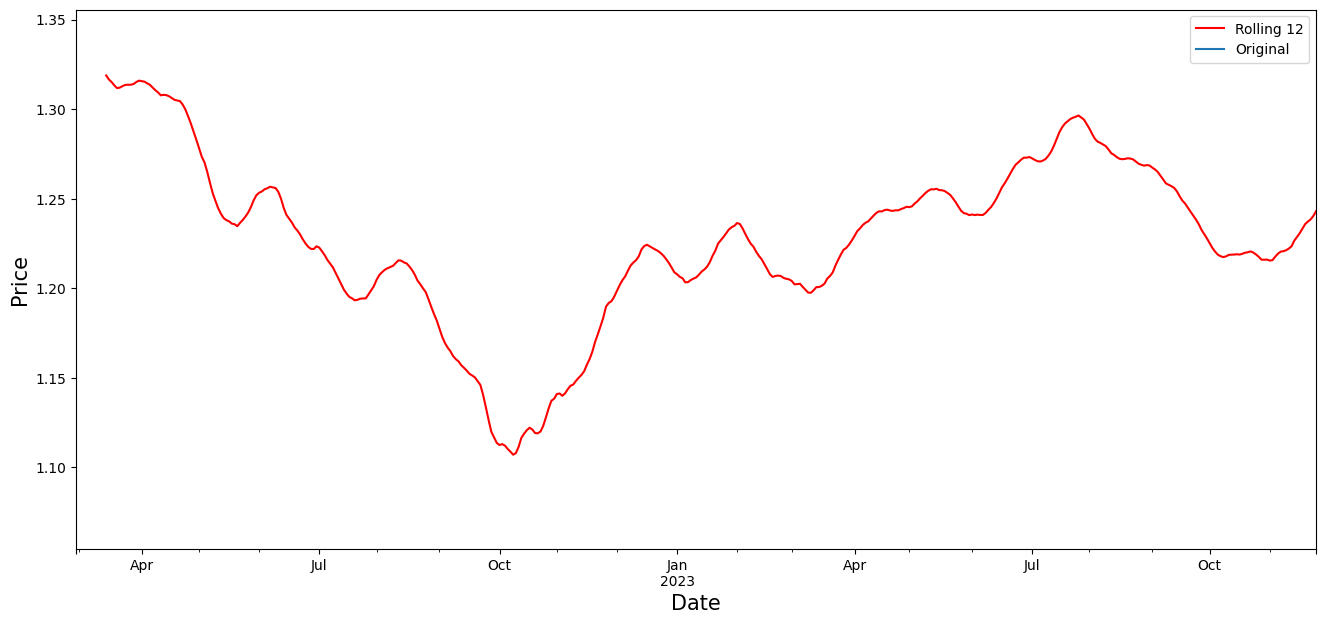

In [7]:
spot_df['SPOT'].rolling(12).mean().plot(figsize=(16,7), color='red', label='Rolling 12')
plt.plot(spot_df.SPOT.to_list(), label='Original')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)

### Time-series decomposition

Decompose the Time-Series into Trend, Seasonality & Residuals Time-Series.

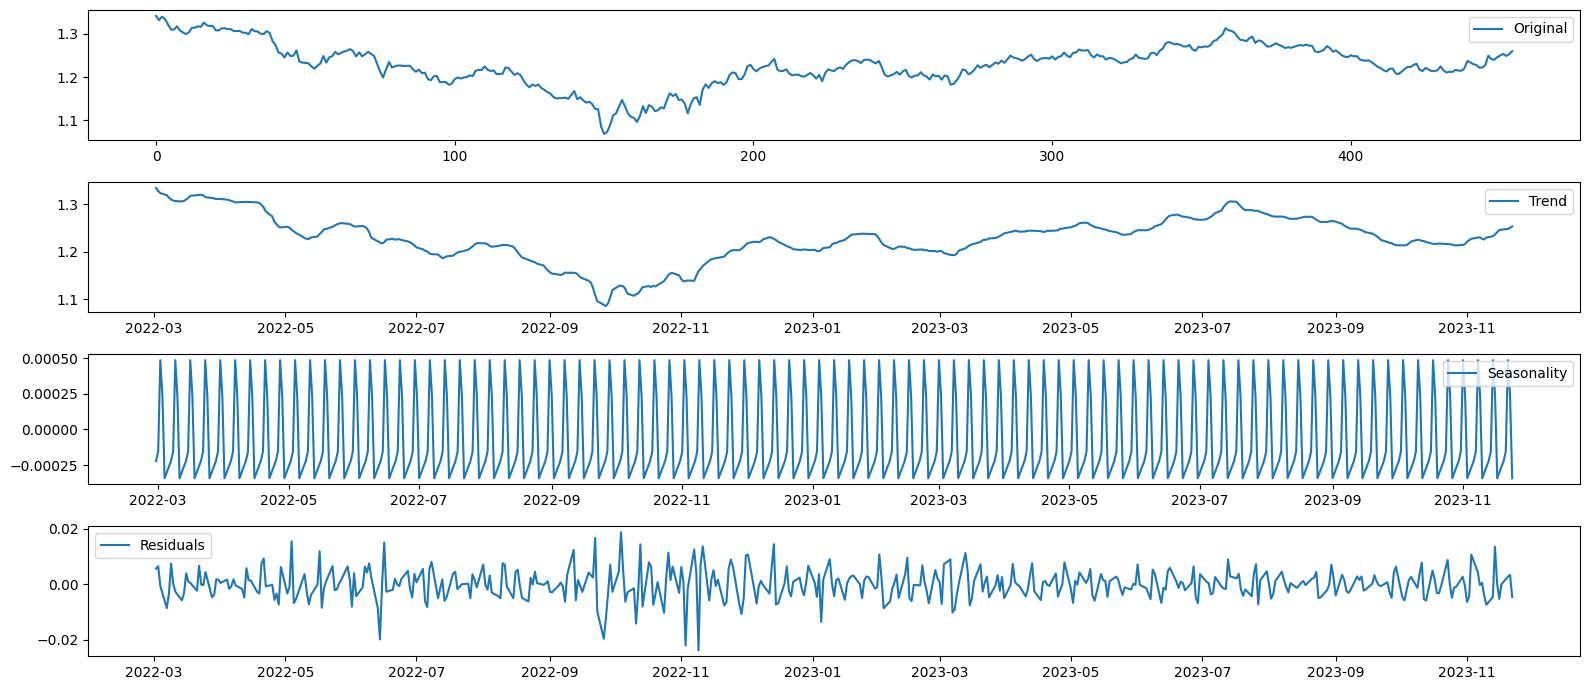

In [8]:
decomposition = seasonal_decompose(spot_df.SPOT) #extrapolate_trend(freq=24
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
plt.subplot(411)
plt.plot(spot_df.SPOT.to_list(), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### First order differencing

Perform a first order differencing to test for stationarity

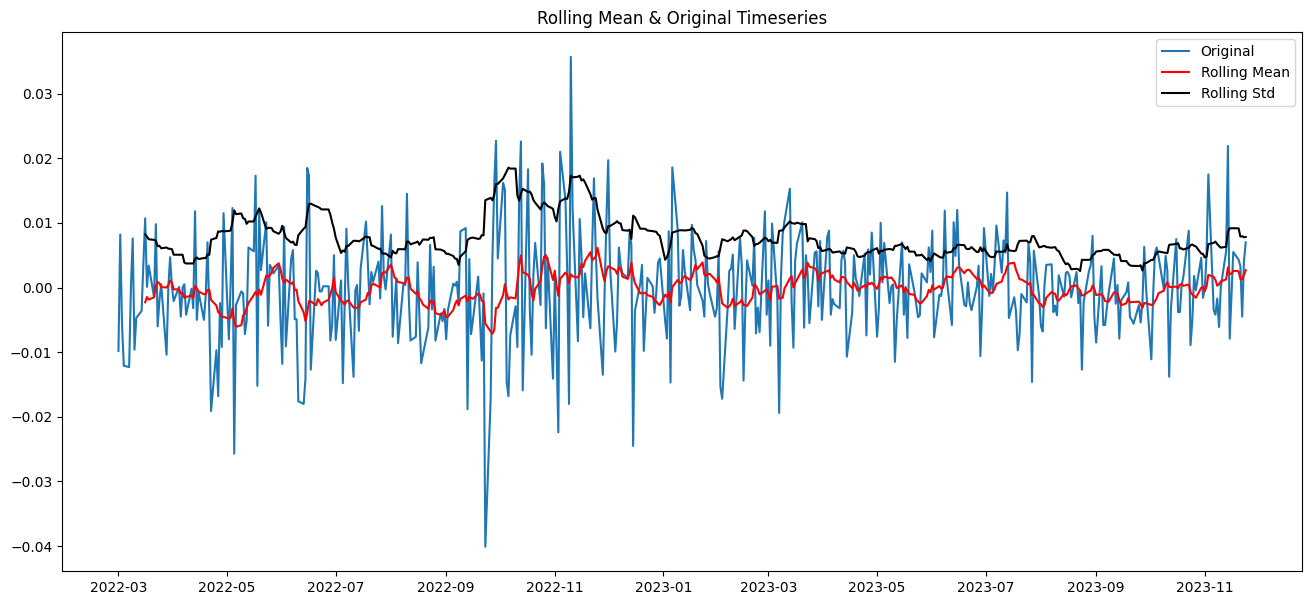

Results of Dickey-Fuller Test:
Test Statistic                -1.610390e+01
p-value                        5.097040e-29
#Lags Used                     1.000000e+00
Number of Observations Used    4.520000e+02
Critical Value (1%)           -3.444900e+00
Critical Value (5%)           -2.867956e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


In [9]:
spot_df['spot_1diff'] = spot_df['SPOT'].diff()
spot_df = spot_df[spot_df['spot_1diff'].notnull()] # drop null rows
test_stationarity(spot_df['spot_1diff'])

The first order difference time-series seems to be stationary

### Plot autocorrelation & partial autocorrelation

To identify the parameters for our ARIMA model

In [10]:
lag_acf = acf(spot_df['spot_1diff'], nlags=50)
lag_pacf = pacf(spot_df['spot_1diff'], nlags=50, method='ols')

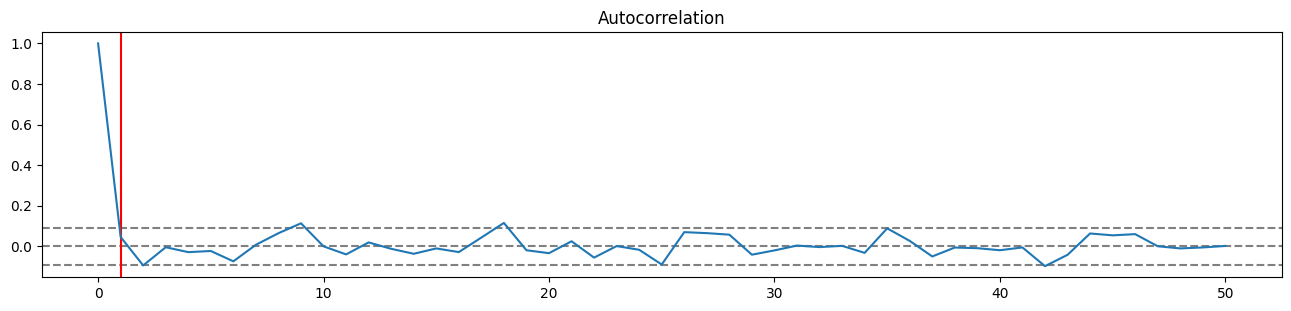

In [11]:
# q
plt.figure(figsize=(16,7))
plt.subplot(211)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(spot_df.spot_1diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(spot_df.spot_1diff)), linestyle='--', color='gray')
plt.axvline(x=1, color='red')
plt.title('Autocorrelation')
plt.plot(lag_acf)

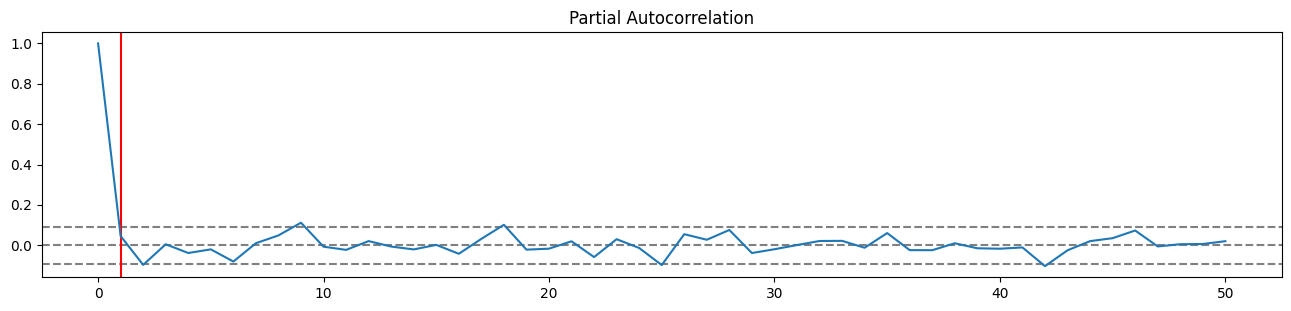

In [12]:
# p
plt.figure(figsize=(16,7))
plt.subplot(211)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(spot_df.spot_1diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(spot_df.spot_1diff)), linestyle='--', color='gray')
plt.axvline(x=1, color='red')
plt.title('Partial Autocorrelation')
plt.plot(lag_pacf)

### Create an ARMA model

In [13]:
new_spot = spot_df['spot_1diff'].resample('D').ffill() # resample per day and fill the gaps
# new_spot = spot_df['SPOT'].resample('D').ffill()
# new_spot = residual.resample('D').ffill().dropna()

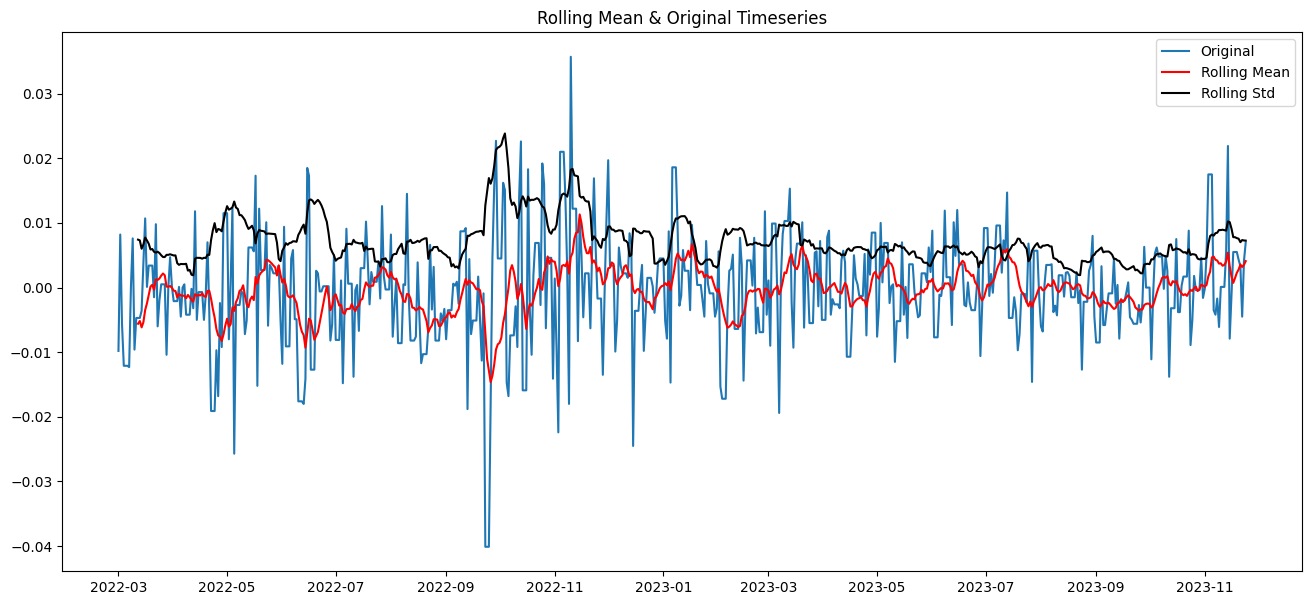

Results of Dickey-Fuller Test:
Test Statistic                -1.773843e+01
p-value                        3.410568e-30
#Lags Used                     0.000000e+00
Number of Observations Used    6.330000e+02
Critical Value (1%)           -3.440723e+00
Critical Value (5%)           -2.866117e+00
Critical Value (10%)          -2.569207e+00
dtype: float64


In [14]:
test_stationarity(new_spot)

Text(0.5, 1.0, 'RSS: 0.0388')

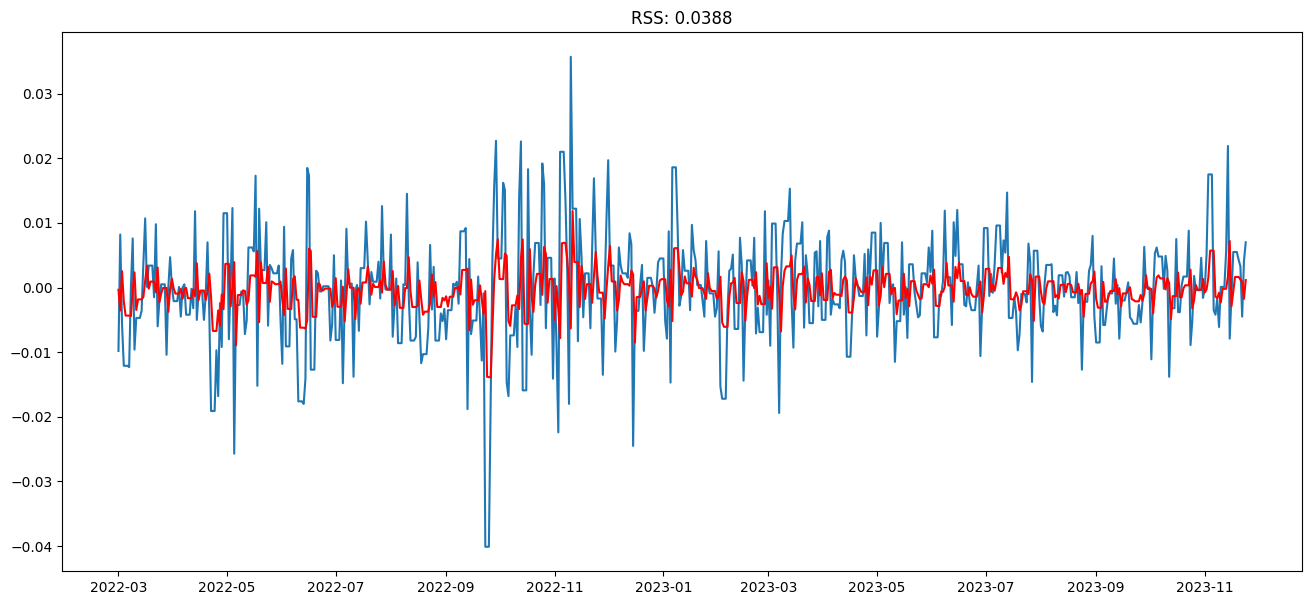

In [17]:
#ARIMA(p,d,q) d = 0 as we use the 1st order differenciated time-series

arma_model = ARIMA(new_spot.astype(float), order=(1,0,1)) 
results = arma_model.fit()
plt.figure(figsize=(16,7))
plt.plot(new_spot.index, new_spot.to_list()) # comparing against the 1st order difference time-series
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results.fittedvalues-new_spot)**2))

In [18]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             spot_1diff   No. Observations:                  634
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2175.773
Date:                Mon, 27 Nov 2023   AIC                          -4343.546
Time:                        14:11:19   BIC                          -4325.738
Sample:                    03-01-2022   HQIC                         -4336.631
                         - 11-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.723      0.470      -0.001       0.001
ar.L1          0.3427      0.085      4.027      0.000       0.176       0.509
ma.L1         -0.0040      0.094     -0.043      0.9

Plot the residuals to see if there is any trend in the data

<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>

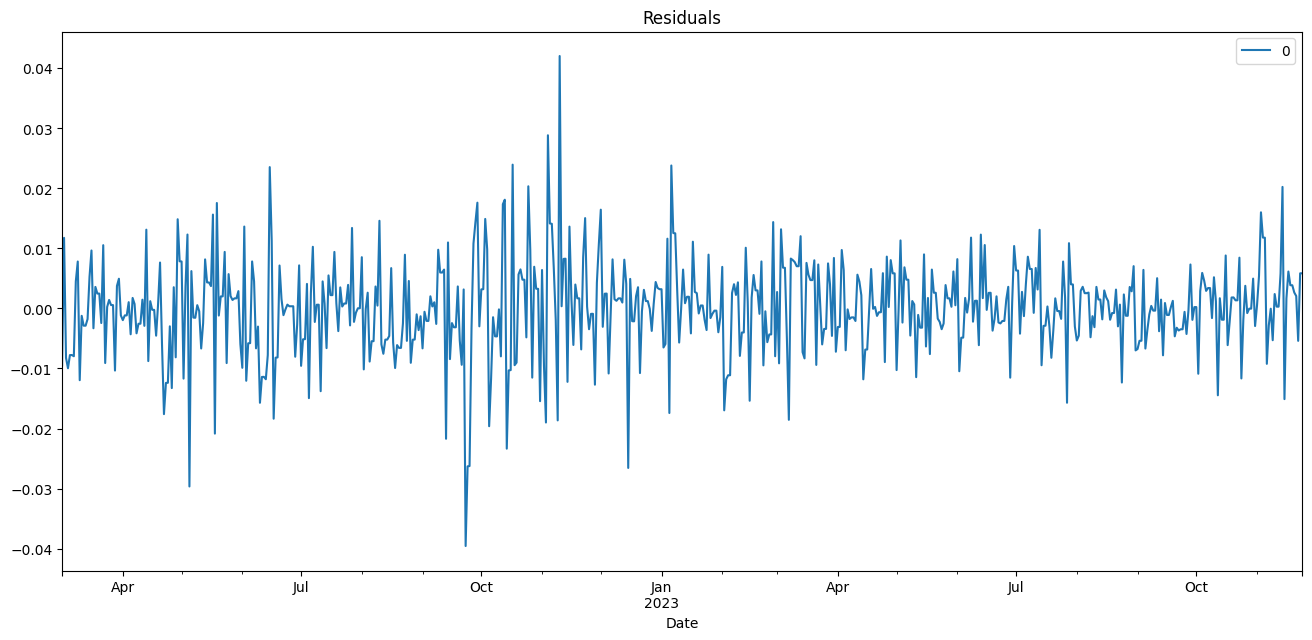

In [19]:
residuals = pd.DataFrame(results.resid)
residuals.plot(figsize=(16,7), title='Residuals')

Check that distribution of residual values is Gaussian

<AxesSubplot:title={'center':'Distribution of residual error values'}, ylabel='Density'>

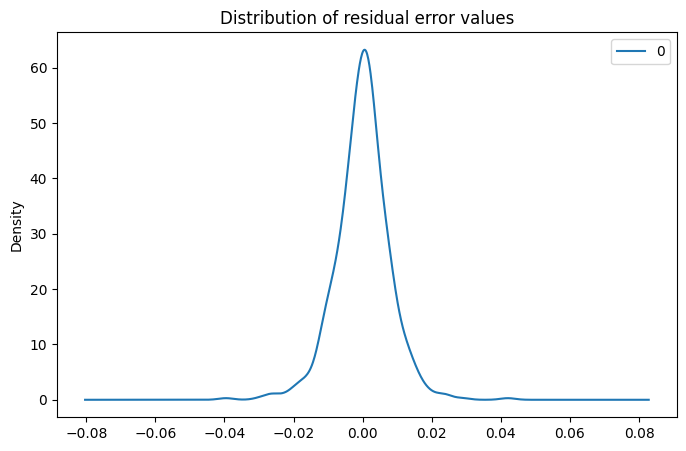

In [20]:
residuals.plot(figsize=(8,5), kind='kde', title='Distribution of residual error values')

#### Bring data back to original scale

Calculate the cumulative sum and add it to a log series with a base value (first SPOT value) since we used the first order difference time-series

In [21]:
predictions_ARIMA = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_cumsum = predictions_ARIMA.cumsum()
predictions_ARIMA_final = pd.Series(spot_df['SPOT'].iloc[0], index=new_spot.index)
predictions_ARIMA_final = predictions_ARIMA_final.add(predictions_ARIMA_cumsum, fill_value=0)
predictions_ARIMA_final.head()

Date
2022-03-01    1.331757
2022-03-02    1.328208
2022-03-03    1.330745
2022-03-04    1.328600
2022-03-05    1.324269
Freq: D, dtype: float64

Text(0.5, 1.0, 'RSS: 0.0388')

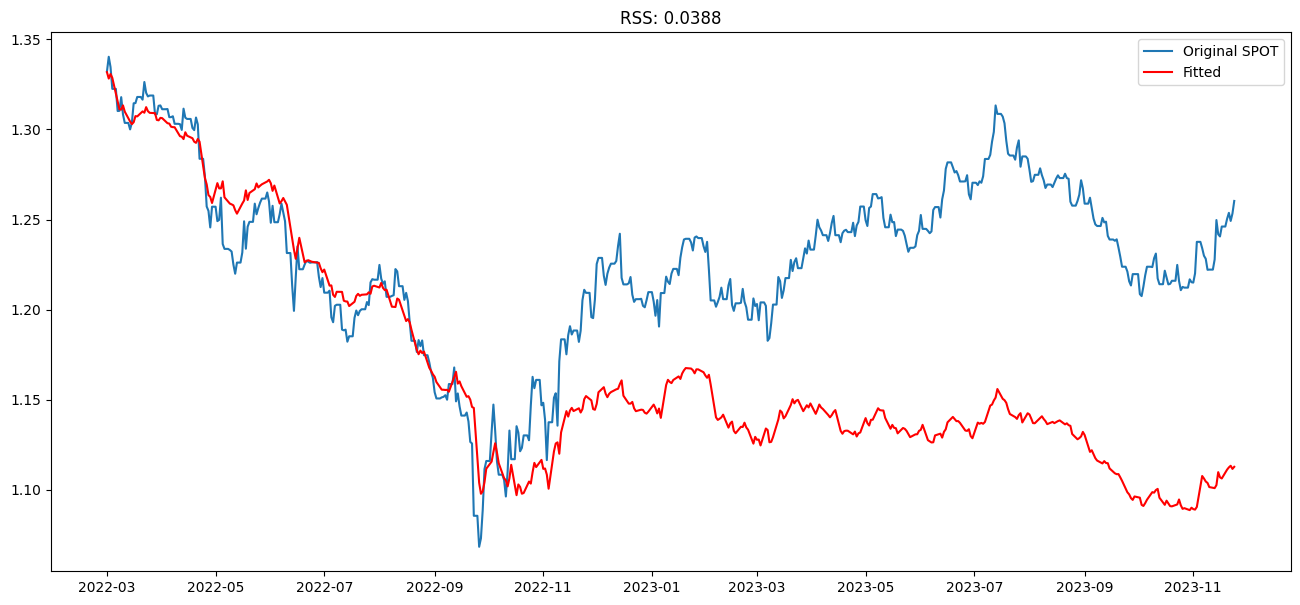

In [22]:
plt.figure(figsize=(16,7))
plt.plot(spot_df.SPOT.resample('D').ffill().index, spot_df.SPOT.resample('D').ffill().to_list(), label='Original SPOT')
plt.plot(predictions_ARIMA_final, color='red', label='Fitted')
plt.legend(loc='best')
plt.title('RSS: %.4f' % sum((results.fittedvalues-new_spot)**2))

#### Exponential Smoothing

We will use triple exponential smoothing (Holt-Winters) for forecasting

In [23]:
new_spot = spot_df.SPOT.resample('D',label='right').ffill().astype(float)

In [24]:
es_model = ExponentialSmoothing(new_spot, 
                             trend='add', damped=False, seasonal='mul', seasonal_periods=12)

es_results = es_model.fit()

Text(0.5, 1.0, 'RSS: 0.0300')

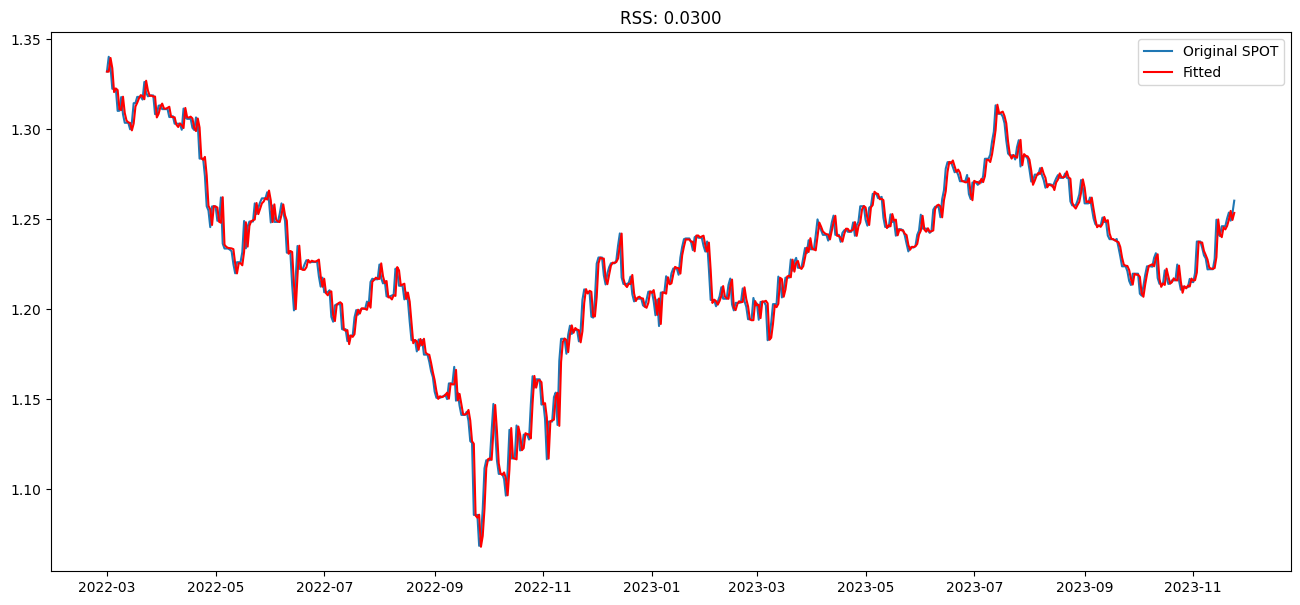

In [25]:
plt.figure(figsize=(16,7))
plt.plot(new_spot, label='Original SPOT')
plt.plot(es_results.fittedvalues, color='red', label='Fitted')
plt.legend(loc='best')
plt.title('RSS: %.4f' % sum((es_results.fittedvalues-new_spot)**2))

In [26]:
predicted_values = es_model.predict(params=es_results.params, start=str(new_spot.index.min()+ timedelta(days=300)), end=str(new_spot.index.max()))
preds = pd.DataFrame(index= pd.date_range(start=str(new_spot.index.min() + timedelta(days=300)), end=str(new_spot.index.max())), data=predicted_values, columns=['SPOT'])

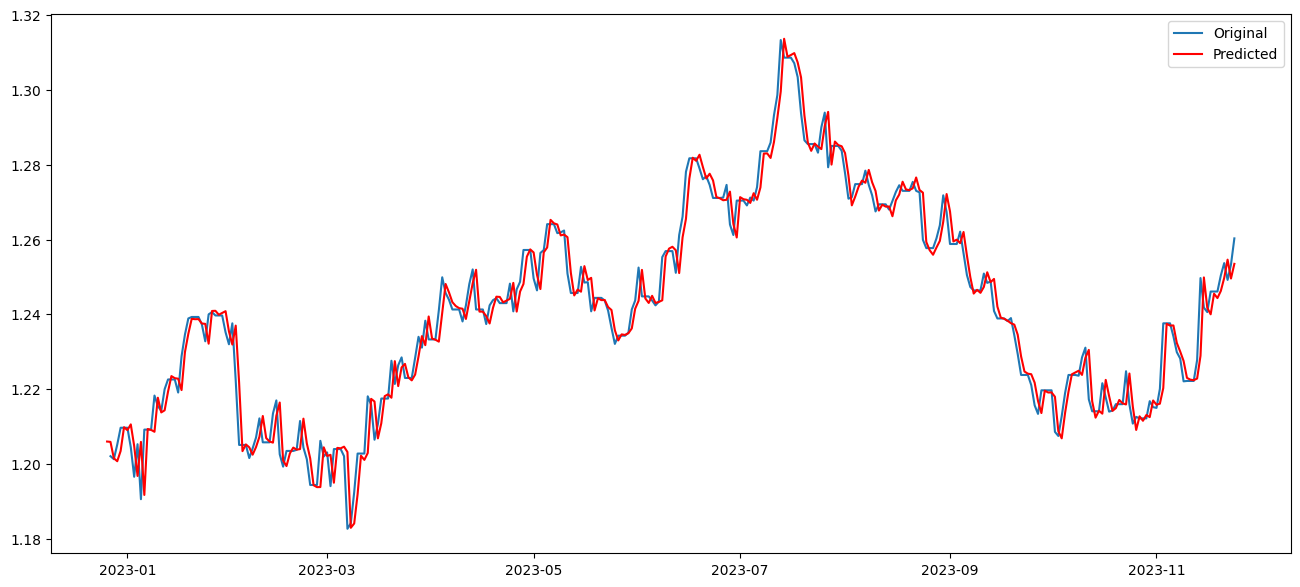

In [27]:
plt.figure(figsize=(16,7))
plt.plot(new_spot[new_spot.index>str(new_spot.index.min() + timedelta(days=300))], label='Original')
plt.plot(preds, label='Predicted', color='red')
plt.legend(loc='best')
plt.show()

### Close the session

In [28]:
rd.close_session()